# Classifieur Random Forest
Le classifieur Random Forest est un modèle robuste et puissant, adapté à des ensembles de données complexes. Il offre une grande flexibilité et est capable de capturer des relations non linéaires entre les caractéristiques, ce qui en fait un choix intéressant pour notre problème de classification des espèces de feuilles

In [2]:
import DataManagement as DM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

dataset = DM.Dataset('data/train.csv')
dataset.split_data(test_size=0.3, seed=0, stratified=True)
dataset.info()

(693, 192) (297, 192)
Index(['id', 'species', 'label', 'margin1', 'margin2', 'margin3', 'margin4',
       'margin5', 'margin6', 'margin7',
       ...
       'texture55', 'texture56', 'texture57', 'texture58', 'texture59',
       'texture60', 'texture61', 'texture62', 'texture63', 'texture64'],
      dtype='object', length=195)
##### Informations #####
  - Nb classes   : 99 ( Dim : 195 )
  - Nb samples   : 990
     - Training  : 693 ( 70.0 % )
     - Test      : 297 ( 30.0 % )
########################


Puisque qu'on a beaucoup de classe et très peu de données par classe, on a séparé notre ensemble de données de façon à avoir autant de données dans chaque classe.

## Entrainement

Pour notre classifieur Random Forest, nous utilisons également trois hyperparamètres clés :

- Le nombre d'arbres dans la forêt (n_estimators).
- La profondeur maximale de chaque arbre (max_depth). Une profondeur à None indique qu'il n'y a pas de restriction sur celle-ci.
- Le nombre minimal d'échantillons requis pour diviser un nœud (min_samples_split).

Bien que le nombre d'arbres soit souvent l'hyperparamètre le plus crucial, nous explorons également l'impact des autres hyperparamètres sur les performances du modèle.

### Recherche des hyperparamètres

On utilise une validation croisée à 5 plis. On utilise un nombre de plis assez petit parce qu'on a très peu de données par classe (seulement 7) et on veut éviter d'avoir des plis qui n'ont pas de données pour certaines classes.

Concernant le choix des valeurs d'hyperparamètres à tester, afin que l'entraînement ne soit pas trop long, nous avons fait des essais préalables pour déterminer les valeurs d'hyperparamètres qui revenaient le plus souvent comme optimales, et nous avons adapté la recherche autour de ces valeurs là. Cela est notamment le cas pour le nombre d'estimateurs, qui était toujours au-dessus de 60.

In [12]:
hyperparameters_rf = {
    'n_estimators': range(60, 101, 10),
    'max_depth': [None, 3, 5, 7,100],
    'min_samples_split': [2, 5, 10],
}

grid, results = DM.train_model(RandomForestClassifier(), hyperparameters_rf, dataset)
print('Best:', grid.best_params_, 'with score {:.3}'.format(grid.best_score_))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Best: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 80} with score 0.971


Suite à l'entraînement, nous pouvons visualiser le premier arbre de décision issu du modèle optimal qui a été trouvé. Cette visualisation textuelle et graphique offre un aperçu détaillé des conditions de décision et des caractéristiques clés utilisées par le modèle pour effectuer des prédictions sur les classes des données.

Tree 1:
|--- shape1 <= 0.00
|   |--- margin31 <= 0.02
|   |   |--- shape15 <= 0.00
|   |   |   |--- margin4 <= 0.11
|   |   |   |   |--- margin39 <= 0.00
|   |   |   |   |   |--- shape23 <= 0.00
|   |   |   |   |   |   |--- margin57 <= 0.00
|   |   |   |   |   |   |   |--- shape51 <= 0.00
|   |   |   |   |   |   |   |   |--- class: 36.0
|   |   |   |   |   |   |   |--- shape51 >  0.00
|   |   |   |   |   |   |   |   |--- class: 15.0
|   |   |   |   |   |   |--- margin57 >  0.00
|   |   |   |   |   |   |   |--- shape31 <= 0.00
|   |   |   |   |   |   |   |   |--- margin21 <= 0.01
|   |   |   |   |   |   |   |   |   |--- texture12 <= 0.03
|   |   |   |   |   |   |   |   |   |   |--- margin6 <= 0.19
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- margin6 >  0.19
|   |   |   |   |   |   |   |   |   |   |   |--- class: 38.0
|   |   |   |   |   |   |   |   |   |--- texture12 >  0.03
|   |   |   |   |   |   |   |   |   

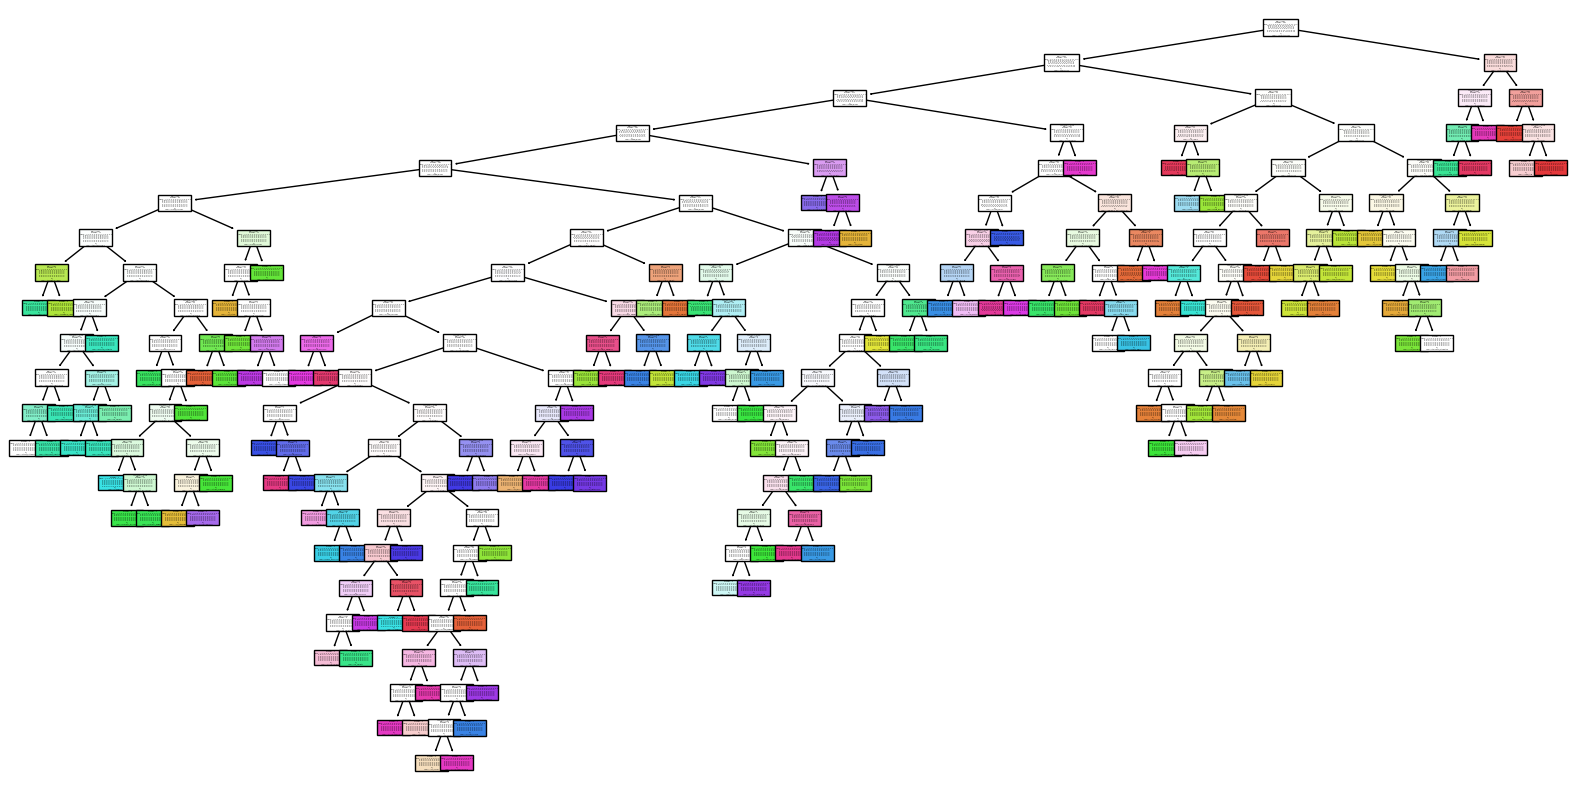

In [13]:
# Importation de la fonction plot_tree
from sklearn.tree import plot_tree, export_text


best_rf_model = grid.best_estimator_
# Visualiser le premier arbre de la Random Forest
tree = best_rf_model.estimators_[0]

# Affichage textuel de l'arbre
tree_text = export_text(tree, feature_names=dataset.data.columns[3:].tolist())
print(f"Tree 1:\n{tree_text}")

# Affichage graphique de l'arbre
plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, feature_names=dataset.data.columns[3:], class_names=dataset.classes)
plt.show()


Dans l'affichage textuel de l'arbre, chaque nœud représente une décision basée sur une caractéristique particulière. Les nœuds feuilles indiquent les prédictions pour chaque classe. En examinant ces conditions de division et les valeurs seuils associées, on peut avoir un aperçu des caractéristiques qui ont été jugées importantes par le modèle pour effectuer des prédictions. Par exemple, on peut observer que la caractéristique shape10 = 0.00 a été déterminante et influence les divisions de l'arbre.

L'affichage graphique, quant à lui, illustre visuellement la structure de l'arbre. Les nœuds internes représentent les conditions de division, les feuilles représentent les résultats de classification, et les branches indiquent le flux de décision. Cette représentation graphique est utile pour visualiser les chemins de décision et comprendre comment le modèle segmente l'espace des caractéristiques pour effectuer des prédictions.

### Analyse de l'entrainement

Le nombre optimal d'estimateurs (n_estimators) est de 80, indiquant ainsi une configuration où le modèle Random Forest se base sur un ensemble significatif d'arbres de décision pour effectuer des prédictions sur les espèces de feuilles. On peut examiner les performances du modèle en considérant le score associé à ce nombre particulier d'estimateurs et évaluer l'influence des autres hyperparamètres sur ces résultats.

In [19]:
results[results.param_n_estimators == grid.best_params_['n_estimators']].sort_values(by='rank_test_score')

,param_n_estimators,param_max_depth,param_min_samples_split,mean_test_score,rank_test_score
7,80,None,5,0.971160,1
67,80,100,5,0.968251,3
62,80,100,2,0.963925,7
2,80,None,2,0.962527,9
72,80,100,10,0.946617,25
12,80,None,10,0.939391,28
52,80,7,5,0.790762,35
47,80,7,2,0.786456,36
57,80,7,10,0.743124,44
32,80,5,2,0.682640,49


Pour la profondeur maximale des arbres, on constate que l'absence de limite de profondeur semble être préférable, car elle obtient le meilleur score (0.966823) par rapport aux autres valeurs de max_depth.

L'impact de la division minimale des échantillons (min_samples_split) sur les performances est également observé. Un nombre de 5 pour min_samples_split semble être plus performant que 2 et 10.

On peut tracer un graphique du score en fonction des différentes valeurs d'hyperparamètres pour réellement voir l'impact de leur variation sur le score.

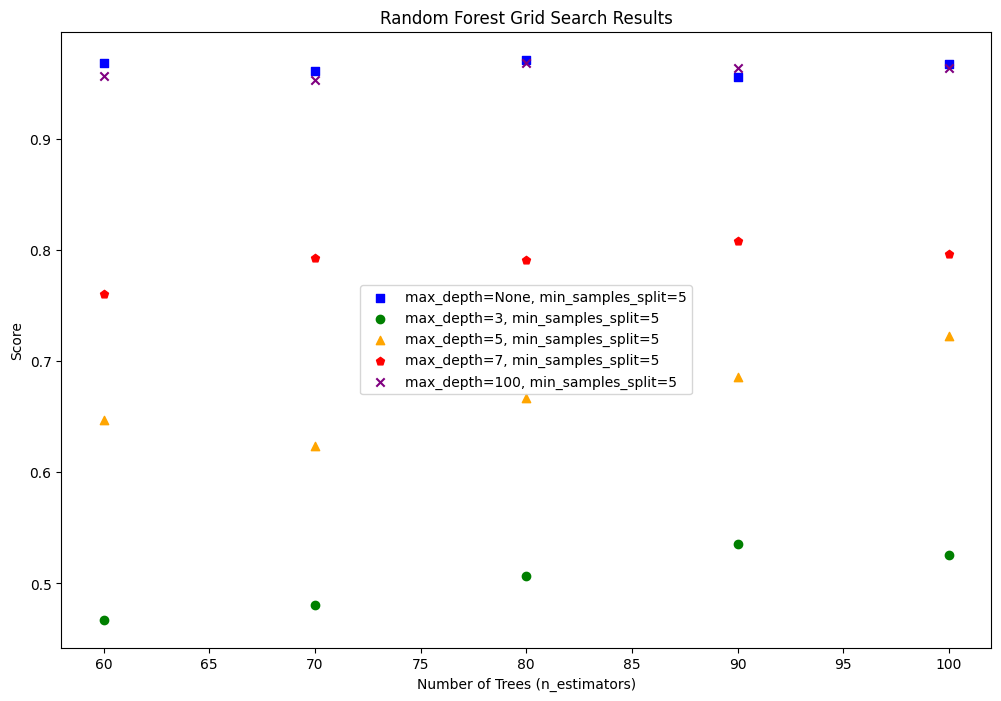

In [20]:
plt.figure(figsize=(12, 8))

# Exploration du nombre d'arbres (n_estimators)
plt.scatter(results.query('param_max_depth.isna() and param_min_samples_split == 5')['param_n_estimators'],
            results.query('param_max_depth.isna() and param_min_samples_split == 5')['mean_test_score'],
            marker='s', color='blue', label='max_depth=None, min_samples_split=5')
plt.scatter(results.query('param_max_depth == 3 and param_min_samples_split == 5')['param_n_estimators'],
            results.query('param_max_depth == 3 and param_min_samples_split == 5')['mean_test_score'],
            marker='o', color='green', label='max_depth=3, min_samples_split=5')
plt.scatter(results.query('param_max_depth == 5 and param_min_samples_split == 5')['param_n_estimators'],
            results.query('param_max_depth == 5 and param_min_samples_split == 5')['mean_test_score'],
            marker='^', color='orange', label='max_depth=5, min_samples_split=5')
plt.scatter(results.query('param_max_depth == 7 and param_min_samples_split == 5')['param_n_estimators'],
            results.query('param_max_depth == 7 and param_min_samples_split == 5')['mean_test_score'],
            marker='p', color='red', label='max_depth=7, min_samples_split=5')
plt.scatter(results.query('param_max_depth == 100 and param_min_samples_split == 5')['param_n_estimators'],
            results.query('param_max_depth == 100 and param_min_samples_split == 5')['mean_test_score'],
            marker='x', color='purple', label='max_depth=100, min_samples_split=5')



plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Score")
plt.title("Random Forest Grid Search Results")
plt.legend()
plt.show()


On observe que plus la profondeur maximale d'arbre augmente, mieux sont les performances, et on obtient le meilleur résultat quand elle est illimitée. De cette façon, le noeuds sont étendus jusqu'à ce que toutes les feuilles de l'arbre soient pures (ne contenant uniquement des échantillons appartenant à une seule classe), où contiennent moins d'échantillons que la valeur de min_samples_split. Ce résultat n'est donc pas suprenant, car une telle profondeur conduit à une meilleure adaptation aux données d'entraînement, car l'arbre peut capturer des relations plus complexes entre les caractéristiques.

En outre, nous observons que plus le nombre d'arbres augmente, mieux sont les performances des modèles utilisant un  nombre limité de profondeur d'arbre. Cela s'explique par le fait que la limitation de profondeur est compensée par une diversité d'arbres et donc moins de surajustement. Cependant, on voit que pour une profondeur illimitée, les performances s'essouflent si on augmente le nombre d'arbres. En effet, il devient de plus en plus dur d'obtenir des améliorations significatives des prédictions, et les coûts computationels ne font qu'augmenter dans ce cas de figure, expliquant la baisse de performances.

## Évaluation

On évalue le meilleur modèle entrainé à l'aide de notre ensemble de test. Pour l'évaluation, on regarde les métriques suivantes:
- La précision ("precision") : la proportion de données appartenant réellement à leur classe prédite
- Le rappel ("recall") : la proportion des données bien classées (la justesse des prédictions pour une classe)
- Le f1-score : la moyenne harmonique de la précision et du rappel

Comme nous sommes dans une situation de classification multi-classe, on calcule ces métriques individuellement pour chaque classe. On peut ensuite regarder la distribution des résultats pour évaluer notre modèle.

### Averages ###
   - precision : 97.811% ± 7.490%
   - recall    : 97.306% ± 9.131%
   - f1_score  : 97.249% ± 7.212%
################


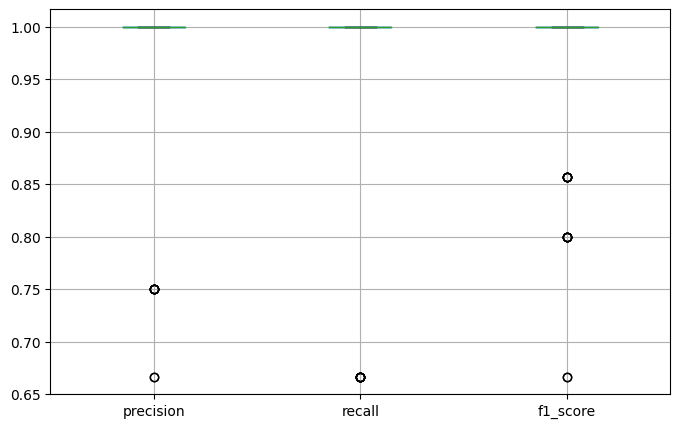

In [16]:
test_preds = grid.predict(dataset.x_test)
test_reports = DM.evaluate_predictions(dataset.t_test, test_preds, dataset.classes)

Comme nous avons 99 classes, il n'est pas pratique de regarder les résultats pour chacune d'entre elles. On regarde plutôt la moyenne de chaque métrique sur l'ensemble des classes. On peut alors voir que notre modèle fonctionne très bien. Il est à la fois précis et juste.

Comme on peut le voir dans le boxplot, les prédictions sont parfaites (métriques à 1.0) pour la grande majorité des classes. Il y a cependant des classes pour lesquelles le modèle a moins bien performé. Regardons de quelles classes il s'agit.

In [17]:
bad_classes = test_reports.query('precision < 1.0 or recall < 1.0')
print(bad_classes)
print('Sum:', len(bad_classes))

                         precision    recall  f1_score
Alnus_Cordata             0.750000  1.000000  0.857143
Arundinaria_Simonii       1.000000  0.666667  0.800000
Cornus_Chinensis          0.750000  1.000000  0.857143
Liriodendron_Tulipifera   1.000000  0.666667  0.800000
Magnolia_Heptapeta        0.750000  1.000000  0.857143
Quercus_Agrifolia         0.750000  1.000000  0.857143
Quercus_Castaneifolia     1.000000  0.666667  0.800000
Quercus_Nigra             1.000000  0.666667  0.800000
Quercus_Palustris         0.750000  1.000000  0.857143
Quercus_Phillyraeoides    1.000000  0.666667  0.800000
Quercus_Pontica           1.000000  0.666667  0.800000
Quercus_Shumardii         0.666667  0.666667  0.666667
Tilia_Oliveri             0.666667  0.666667  0.666667
Tilia_Platyphyllos        0.750000  1.000000  0.857143
Sum: 14


Pour évaluer les performances de notre modèle Random Forest, nous pouvons également utiliser une matrice de confusion pour visualiser les prédictions incorrectes sur l'ensemble de test. La matrice de confusion affiche les classifications réelles par rapport aux classifications prédites, permettant ainsi d'identifier les erreurs et les tendances de notre modèle.

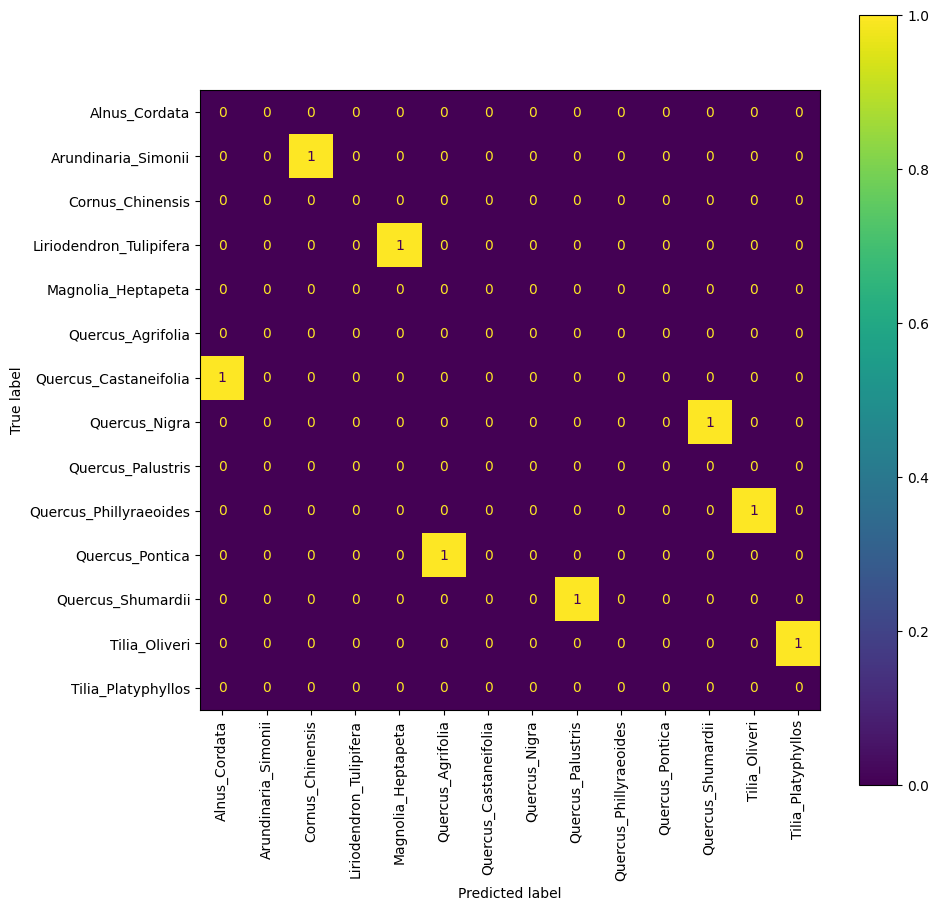

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

# Get all the wrong predictions
bad_preds = DM.extract_bad_predictions(dataset.t_test, test_preds, labels=dataset.classes, ids=dataset.id_test)

# Display them as a confusion matrix
display = ConfusionMatrixDisplay.from_predictions(bad_preds['True Class'], bad_preds['Predicted Class'], 
                                                  labels=bad_classes.index, xticks_rotation='vertical')
display.figure_.set_figwidth(10)
display.figure_.set_figheight(10)

plt.show()

Il ne semble pas se dégager de relation particulière parmis les mauvaises prédictions. Il s'agit donc probablement de données pour lesquelles les caractéristiques sont moins distinctes.

### Conclusion

Le classifieur Random Forest est optimal lorsqu'on utilise 80 arbres, une profondeur illimitée et un nombre minimal d'échantillons pour division à 5. Avec ces hyperparamètres, le modèle performe extrêmement bien, avec des valeurs entre 96 et 97% pour les différentes métriques de performance, et ne semble donc ni sous-apprendre ni sur-apprendre.

Cependant, on doit rappeler que notre jeu de données contient beaucoup de classes (99) et assez peu de données par classes (seulement 10). Notre ensemble de test lui ne contenait que 3 données par classe, ce qui est très peu. Donc il est difficile de dire si les résultats obtenus correspondent aux vraies performances du modèle.